<h3><center>ML Clustering for Pairs Trading<br>
CUNY SPS MSDS<br>
Professor Samuel Gralnick<br>
Team Sugar Cane: Euclid Zhang, Jie Zou, Zhenni Xie<br>
Fall 2022</center></h3>

We previously used a method that searches for pairs within each sector for Pair Trading. This method is not able to find the pairs across sectors that may be good candidates for pairs trading. We may compare each pair of assets in the entire market but doing so is time consuming and it requires intense compute power. Hence, using Machine Learning to cluster assets into clusters and then search for pairs within each cluster would be a more efficient method. In this analysis, we will examine a few clustering methods to confirm if they be used to help identifying pairs for pairs trading.

#### Loading packages

In [111]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas_datareader as dr

#Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle
import pickle

import random
random.seed(618)

import warnings
warnings.filterwarnings("ignore")

#### Loading the Data

Our data is the daily adjusted close price of more than 8000 assets from 9/17/2021 to 9/16/2022. Downloading a large volume of data from Yahoo Finance is difficult. Instead of downloading the most recent data, we will use the data we previously downloaded.

In [112]:
# The data already obtained from yahoo finance is imported.

# The data contains the daily adjusted close price of more than 8000 assets from 9/17/2021 to 9/16/2022
close_prices = read_csv('stock_prices.csv')

# Load the sector information of the assets
stocks = read_csv('https://raw.githubusercontent.com/ezaccountz/Data_618/main/Investment%20Portfolio%20Allocation/Stocks.csv')

In [113]:
# Set the dates as the indexes of the data
close_prices.ref_date = close_prices.ref_date.apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d'))
close_prices.set_index('ref_date', inplace = True)

# Filter out the assets with more than 10% data missing.
close_prices = close_prices.loc[:, close_prices.isnull().mean() < .1]

# Impute the missing values by linear interpolation
close_prices.interpolate(inplace=True)

In [114]:
close_prices.head(5)

,A,AA,AAAU,AAC,AACG,AADI,AADR,AAIC,AAL,AAME,...,ZTS,ZUMZ,ZUO,ZVIA,ZVO,ZWS,ZY,ZYME,ZYNE,ZYXI
ref_date,,,,,,,,,,,,,,,,,,,,,
2021-09-17,172.916931,48.488297,17.420000,9.74,2.68,29.350000,64.510414,3.77,19.73,3.978022,...,197.227448,42.799999,17.049999,11.08,2.51,61.172550,13.87,35.650002,4.23,11.319931
2021-09-20,170.332214,48.120876,17.549999,9.73,2.33,29.090000,62.318977,3.71,20.33,3.808956,...,197.356613,40.900002,16.750000,10.85,2.46,60.854153,13.42,33.070000,4.17,11.077168
2021-09-21,170.431641,45.280899,17.660000,9.74,2.41,29.910000,62.446163,3.72,19.76,3.828846,...,199.731415,39.849998,16.950001,11.20,2.37,59.849205,13.36,30.850000,4.35,11.176072
2021-09-22,171.425751,47.614449,17.600000,9.76,2.44,32.660000,63.835369,3.77,20.52,3.779121,...,200.069260,41.099998,17.120001,11.53,2.42,61.202396,13.38,31.100000,4.41,11.194055
2021-09-23,171.753815,48.220184,17.389999,9.75,2.36,32.330002,65.175674,3.78,20.90,3.888517,...,203.407883,41.880001,17.350000,12.68,2.44,62.366550,13.80,29.760000,4.53,11.095151


#### Data Transformation

For the purpose of clustering, we will be using annual
returns and variance as the variables as they are the indicators of the stock performance and its volatility. Let us prepare the return and volatility variables from the
data.

In [115]:
# Calculate average annual percentage return and volatilities over a theoretical one year period
returns = close_prices.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = close_prices.pct_change().std() * np.sqrt(252)
data=returns

# Filter out the outliers (Annualized Return > 4 or Annulized Volatility > 4)
data = data[abs(data['Returns']) < 4]
data = data[abs(data['Volatility']) < 4]

All the variables should be on the same scale before applying clustering, otherwise a feature with large values will dominate the result. We use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
X=rescaledDataset
X.head(2)

,Returns,Volatility
A,-0.049840,-0.355483
AA,0.532327,0.493938


We can start building the following models and compare their results:

1. KMeans
2. Hierarchical Clustering (Agglomerative Clustering)
3. Affinity Propagation 

#### K-Means Clustering


Usually, we should calculate the Sum of square errors (SSE) within clusters or Silhouette score to find the optimal number of clusters. In this analysis, we have assets categorized into 20 sectors. We would like to check if the majority of assets within the same sector will stay in the same few clusters. Therefore, we would set the number of clusters to be 20.


Let us build the k-means model with 20 clusters and
visualize the results.

In [117]:
nclust=20

# #Fit with k-means
# k_means = cluster.KMeans(n_clusters=nclust, random_state=618)
# k_means.fit(X)

# #Extracting labels 
# target_labels = k_means.predict(X)

# Load the saved results instead of running above codes again to save time
file_data = open("k_means.pkl", 'rb') 
k_means = pickle.load(file_data)
file_data = open("target_labels.pkl", 'rb') 
target_labels = pickle.load(file_data)

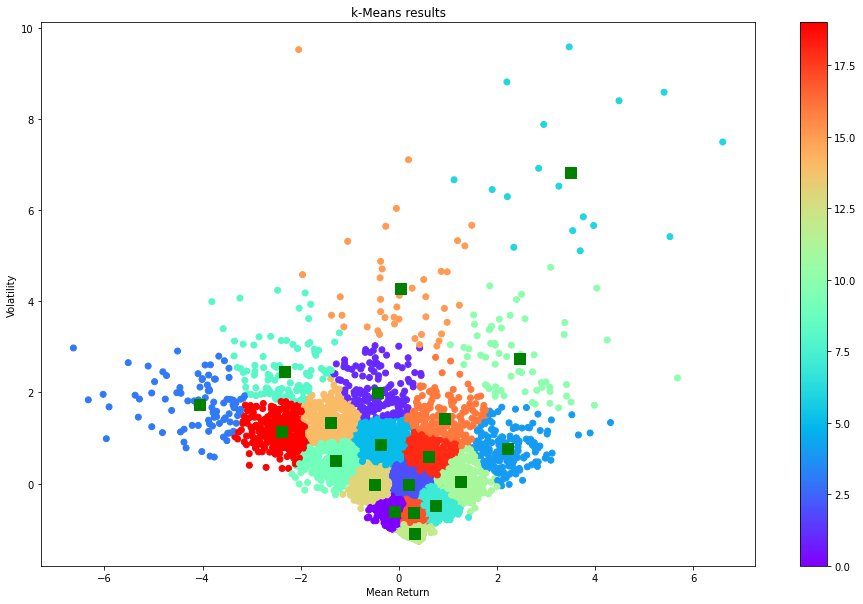

In [118]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)
plt.show()

As showed in the graph, assets with similar Mean Return and Volatility are clustered into the same group and each group is enclosed by a clear boundary. The KMean method is doing well in clustering the assets.

#### Hierarchical Clustering (Agglomerative Clustering)

Again, we are setting the number of clusters to be 20

In [119]:
nclust = 20
# hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
# clust_labels1 = hc.fit_predict(X)

# Load the saved results instead of running above codes again to save time
file_data = open("hc.pkl", 'rb') 
hc = pickle.load(file_data)
file_data = open("clust_labels1.pkl", 'rb') 
clust_labels1 = pickle.load(file_data)

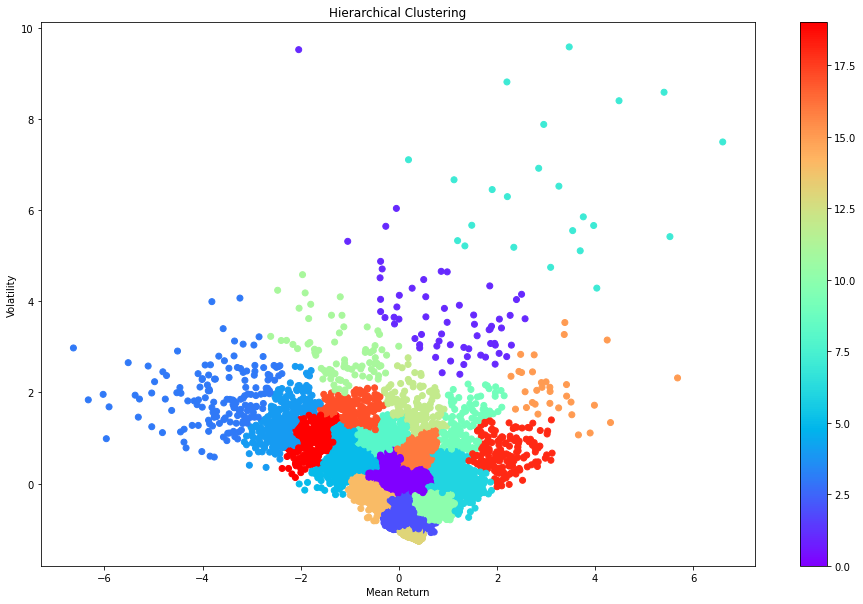

In [120]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

Similar to the plot of k-means clustering, assets with similar Mean Return and Volatility are clustered into the same group. The boundaries are clear but the shapes are not as regular as the ones in k-means clustering.

#### Affinity Propagation

In [121]:
ap = AffinityPropagation(damping = 0.9, max_iter = 1000)
ap.fit(X)
clust_labels2 = ap.predict(X)

# file_data = open("ap.pkl", 'rb') 
# ap = pickle.load(file_data)
# file_data = open("clust_labels2.pkl", 'rb') 
# clust_labels2 = pickle.load(file_data)

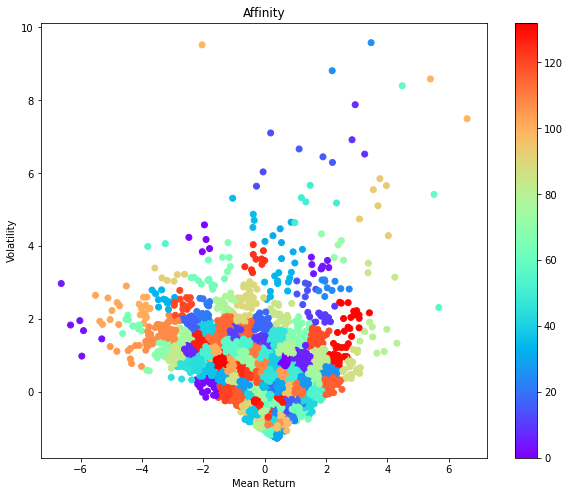

In [122]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

The number of clusters is determined by the Affinity Propagation model. From the graph, this method creates too many clusters, which is not suitable for our analysis. we will focus on either the KMean or Hierarchical Clustering model.

We can compare the Silhouette Score of the KMean and Hierarchical Clustering models to select our optimal model. The following are the Silhouette Scores of the two models.

In [123]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, clust_labels1, metric='euclidean'))
#print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.3517323801100116
hc 0.30516820009814355


Given the KMean model has the highest Silhouette Score, it is selected as our optimal model.

#### Visualising the return within a cluster

Now, let us visualize the results of the clusters. We would like to check if the assets in the same cluster have similar price movements. Since the number of assets in some clusters is too large, we only plot 10 assets in each cluster.

In [124]:
clustered_series = pd.Series(index=X.index, data=target_labels.flatten())
clustered_series_all = pd.Series(index=X.index, data=target_labels.flatten())
clustered_series = clustered_series[clustered_series != -1]
counts = clustered_series.value_counts()
cluster_vis_list = list(counts.index)[::-1]

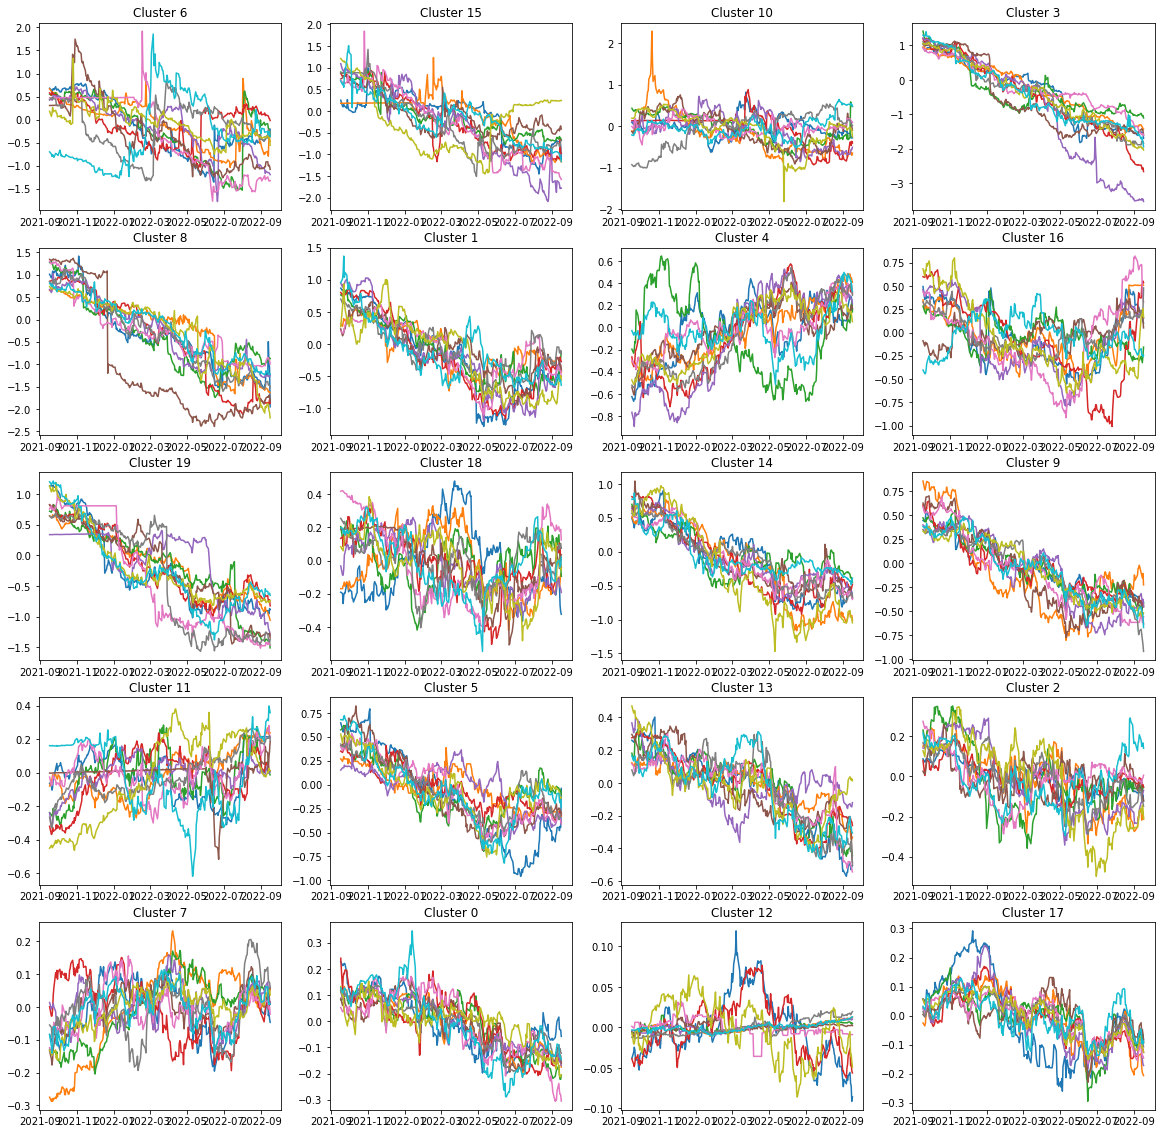

In [125]:
fig, axs = plt.subplots(nrows=5,ncols=4,figsize=(20, 20))

for i in range(0,20):

    clust = cluster_vis_list[i]
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(close_prices.loc[:, tickers[:10]].mean())
    sub_data = np.log(close_prices.loc[:, tickers[:10]]).sub(means)
    axs[i//4, i%4].plot(sub_data)
    axs[i//4, i%4].set_title('Cluster %d' % clust)

plt.show()

Most of the assets within the same cluster have similar patterns, with a few exceptions. The exceptions tell us that assets with similar mean return and volatility may not have the same pattern. We will perform cointegration test to identify pairs within each cluster.

#### Clusters VS Sectors

Now, let's check if the assets within each Sector are majoritively clustered in the same few clusters

In [126]:
result = data.copy('deep')
result['Cluster'] = target_labels
result = result.merge(stocks[['Ticker','Type','Sector']], how='inner', left_index=True, right_on = 'Ticker')
result.set_index('Ticker', inplace=True)

In [127]:
clust_sector_count = pd.DataFrame(result.groupby(['Sector','Cluster'])['Cluster'].count())
sectors = list(set(result.Sector))

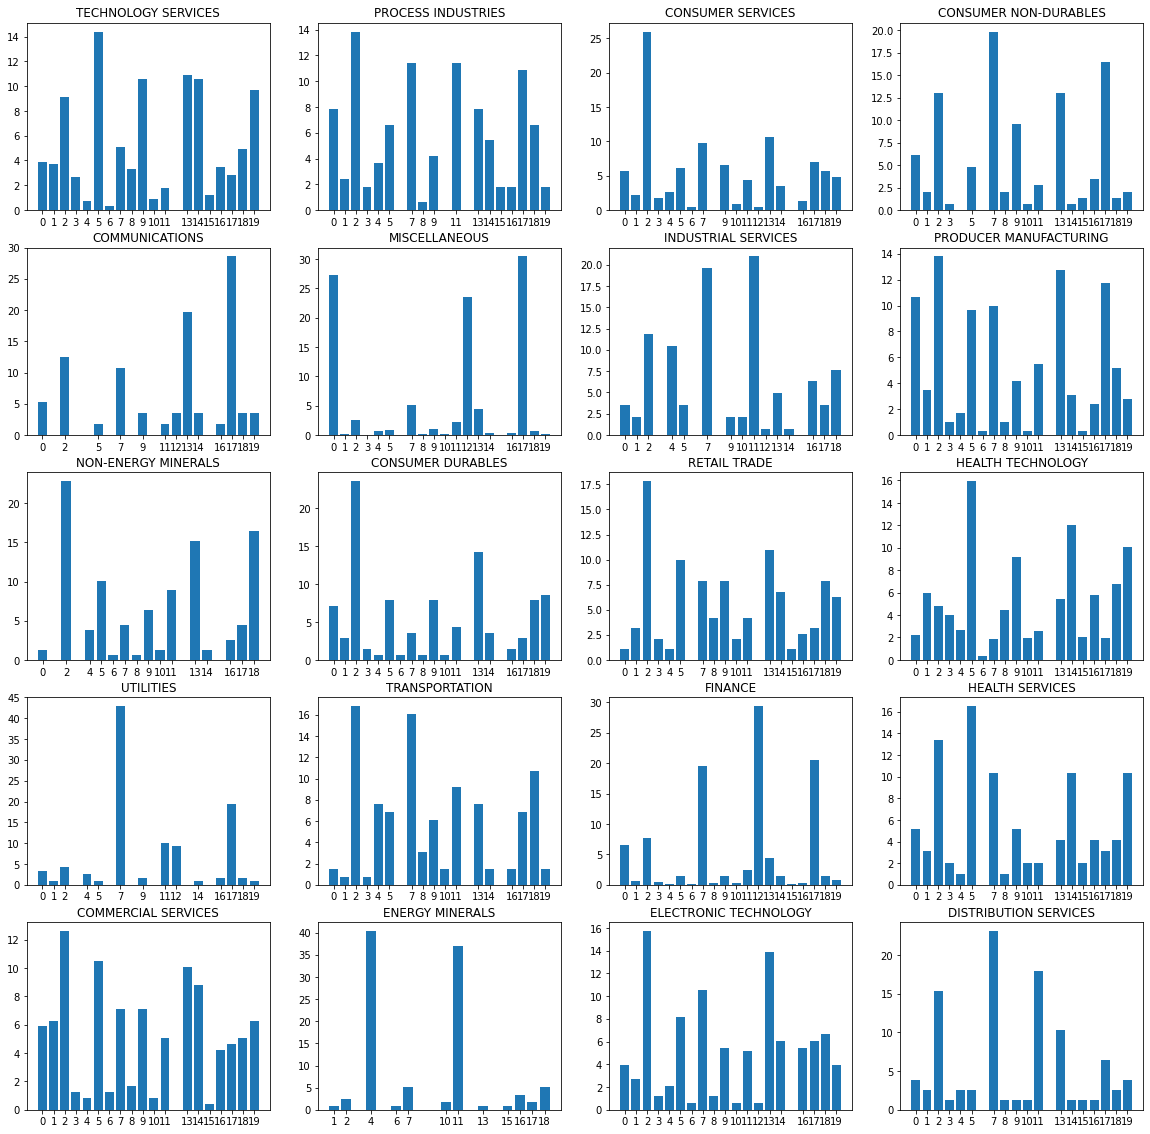

In [128]:
fig, axs = plt.subplots(nrows=5,ncols=4,figsize=(20, 20))

for i in range(0,20):

    axs[i//4, i%4].bar(clust_sector_count.loc[sectors[i]].index,
                       100*clust_sector_count.loc[sectors[i]].Cluster/clust_sector_count.loc[sectors[i]].Cluster.sum())
    axs[i//4, i%4].set_xticks(clust_sector_count.loc[sectors[i]].index)
    axs[i//4, i%4].set_title(sectors[i])

plt.show()

Some of the Sectors such as Utilities and Energy Minerals, have majority of the assets staying the same clusters. Other Sectors such as Transportation and Technology Service, have assets distributed into many different clusters. This shows that finding pairs within sectors may work for some sectors, but not for the others.

#### Finding Pairs

In [129]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(0,(n-1)):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [130]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
# print ("Clusters formed: %d" % len(ticker_count_reduced))
# print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

In [131]:
from statsmodels.tsa.stattools import coint
# cluster_dict = {}
# for i, which_clust in enumerate(ticker_count_reduced.index):
#     tickers = clustered_series[clustered_series == which_clust].index   
#     score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
#         close_prices[tickers]
#     )
#     cluster_dict[which_clust] = {}
#     cluster_dict[which_clust]['score_matrix'] = score_matrix
#     cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
#     cluster_dict[which_clust]['pairs'] = pairs

# Load the saved results instead of running above codes again to save time
file_data = open("cluster_dict.pkl", 'rb') 
cluster_dict = pickle.load(file_data)

In [132]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [133]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 443257
In those pairs, there are 8573 unique tickers.


In [134]:
pair_summary = pd.DataFrame(pairs)
pair_summary.columns=['Ticker_x','Ticker_y']
pair_summary = pair_summary.merge(result['Sector'],how="left", left_on="Ticker_x",right_index=True)
pair_summary = pair_summary.merge(result['Sector'],how="left", left_on="Ticker_y",right_index=True)
pair_summary

,Ticker_x,Ticker_y,Sector_x,Sector_y
0,AAON,APD,PRODUCER MANUFACTURING,PROCESS INDUSTRIES
1,AAON,BCPC,PRODUCER MANUFACTURING,CONSUMER NON-DURABLES
2,AAON,BHFAL,PRODUCER MANUFACTURING,FINANCE
3,AAON,CATC,PRODUCER MANUFACTURING,FINANCE
4,AAON,CBOE,PRODUCER MANUFACTURING,FINANCE
...,...,...,...,...
443252,BAOS,PBTS,COMMERCIAL SERVICES,TECHNOLOGY SERVICES
443253,BKKT,TXMD,COMMERCIAL SERVICES,HEALTH TECHNOLOGY
443254,CPTN,IINN,ELECTRONIC TECHNOLOGY,HEALTH TECHNOLOGY
443255,IINN,PPSI,HEALTH TECHNOLOGY,PRODUCER MANUFACTURING


The portion of the pairs that have both assets in the same sector is

In [146]:
np.sum(pair_summary.Sector_x == pair_summary.Sector_y)/len(pair_summary)

0.42515064623908927

#### Conclusion

We can see that the strategy of finding pairs within each sector can still find a considerable number of pairs. However, the method fails to find the pairs across sections. The method of using clusters is doing good in finding inter-sector pairs and cross-sector pairs.

We can also find the strength of the relationship between two sectors by checking the number of cross-section pairs. For example, HEALTH SERVICES has the highest number of pairs with HEALTH TECHNOLOGY. The MISCELLANEOUS sector, which contains mainly ETFs, has a strong relation with the FINANCE sector. The FINANCE and MISCELLANEOUS sectors also have strong relations across all other sectors, which is reasonable since all industries need to be funded.

In [147]:
cross_sector = pair_summary.groupby(['Sector_x','Sector_y'])['Sector_x'].count()
cross_sector = pd.DataFrame(cross_sector)
cross_sector.columns = ['count']
cross_sector.reset_index(inplace = True)
cross_sector = pd.pivot(cross_sector, index=['Sector_y'], columns = 'Sector_x', values = 'count').fillna(0)
cross_sector.index.name = None
cross_sector.columns.name = None
for i in range(0, cross_sector.shape[0]):
    for j in range(i+1, cross_sector.shape[1]):
        sum = cross_sector.iloc[i,j] + cross_sector.iloc[j,i]
        cross_sector.iloc[i,j] = sum
        cross_sector.iloc[j,i] = sum
cross_sector

,COMMERCIAL SERVICES,COMMUNICATIONS,CONSUMER DURABLES,CONSUMER NON-DURABLES,CONSUMER SERVICES,DISTRIBUTION SERVICES,ELECTRONIC TECHNOLOGY,ENERGY MINERALS,FINANCE,HEALTH SERVICES,HEALTH TECHNOLOGY,INDUSTRIAL SERVICES,MISCELLANEOUS,NON-ENERGY MINERALS,PROCESS INDUSTRIES,PRODUCER MANUFACTURING,RETAIL TRADE,TECHNOLOGY SERVICES,TRANSPORTATION,UTILITIES
COMMERCIAL SERVICES,266,128,345,263,478,127,707,100,1936,242,2771,166,3183,200,313,540,524,1625,203,88
COMMUNICATIONS,128,21,81,97,152,50,191,21,1031,32,354,39,1244,54,88,142,103,300,45,63
CONSUMER DURABLES,345,81,126,188,307,128,598,64,1071,136,1502,136,2205,170,220,394,326,1002,156,64
CONSUMER NON-DURABLES,263,97,188,94,255,131,393,45,1952,73,871,103,2568,125,173,303,230,711,126,120
CONSUMER SERVICES,478,152,307,255,304,204,735,141,2753,182,1779,254,5198,352,356,551,456,1118,228,161
DISTRIBUTION SERVICES,127,50,128,131,204,56,269,125,1232,47,388,139,1134,82,112,176,147,295,109,176
ELECTRONIC TECHNOLOGY,707,191,598,393,735,269,538,133,3578,254,2882,304,5236,338,412,800,668,1916,308,208
ENERGY MINERALS,100,21,64,45,141,125,133,162,491,32,294,172,648,154,90,79,112,140,82,88
FINANCE,1936,1031,1071,1952,2753,1232,3578,491,39968,665,4556,1435,99110,1071,1528,3066,1538,3630,1481,2805
HEALTH SERVICES,242,32,136,73,182,47,254,32,665,43,1309,75,827,72,140,240,203,643,71,59
